In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

In [103]:
# import the functions from local directory
sys.path.append("../helpers/functions")
from spike_preprocessing import spike_band_filtering
from spike_detection import detect_spikes, get_waveforms

In [104]:
SAMPLE_RATE = 25000
DT = 1 / SAMPLE_RATE

In [105]:
# load csv into pandas dataframe
df = pd.read_csv("../data/grp_data.csv")

print(df.shape)

df.head()

(100000, 60)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,40,19,-33,-127,-63,8,10,-49,32,9,...,1,-8,2,21,-7,70,-6,26,37,-33
1,34,-9,-38,-82,-91,20,2,-52,33,-6,...,3,-14,-2,2,-1,47,-30,25,27,-55
2,13,-21,-39,-39,-89,17,-7,-40,15,-28,...,-15,-18,2,7,-3,8,-29,6,3,-83
3,-5,-15,-33,-11,-58,-7,-2,-9,3,-34,...,-28,-28,4,32,-24,-20,1,-14,-29,-91
4,-15,5,-21,-13,-14,-37,-2,5,-3,-25,...,-45,-46,-7,58,-46,-26,12,-6,-45,-64


## Raw Data

First, let's look at the raw signals from a small group of electrodes

In [106]:
# choose some channels which are close to each other
channels = ["47", "48", "49", "50"]

# convert channel data to numpy array
data = df[channels].values

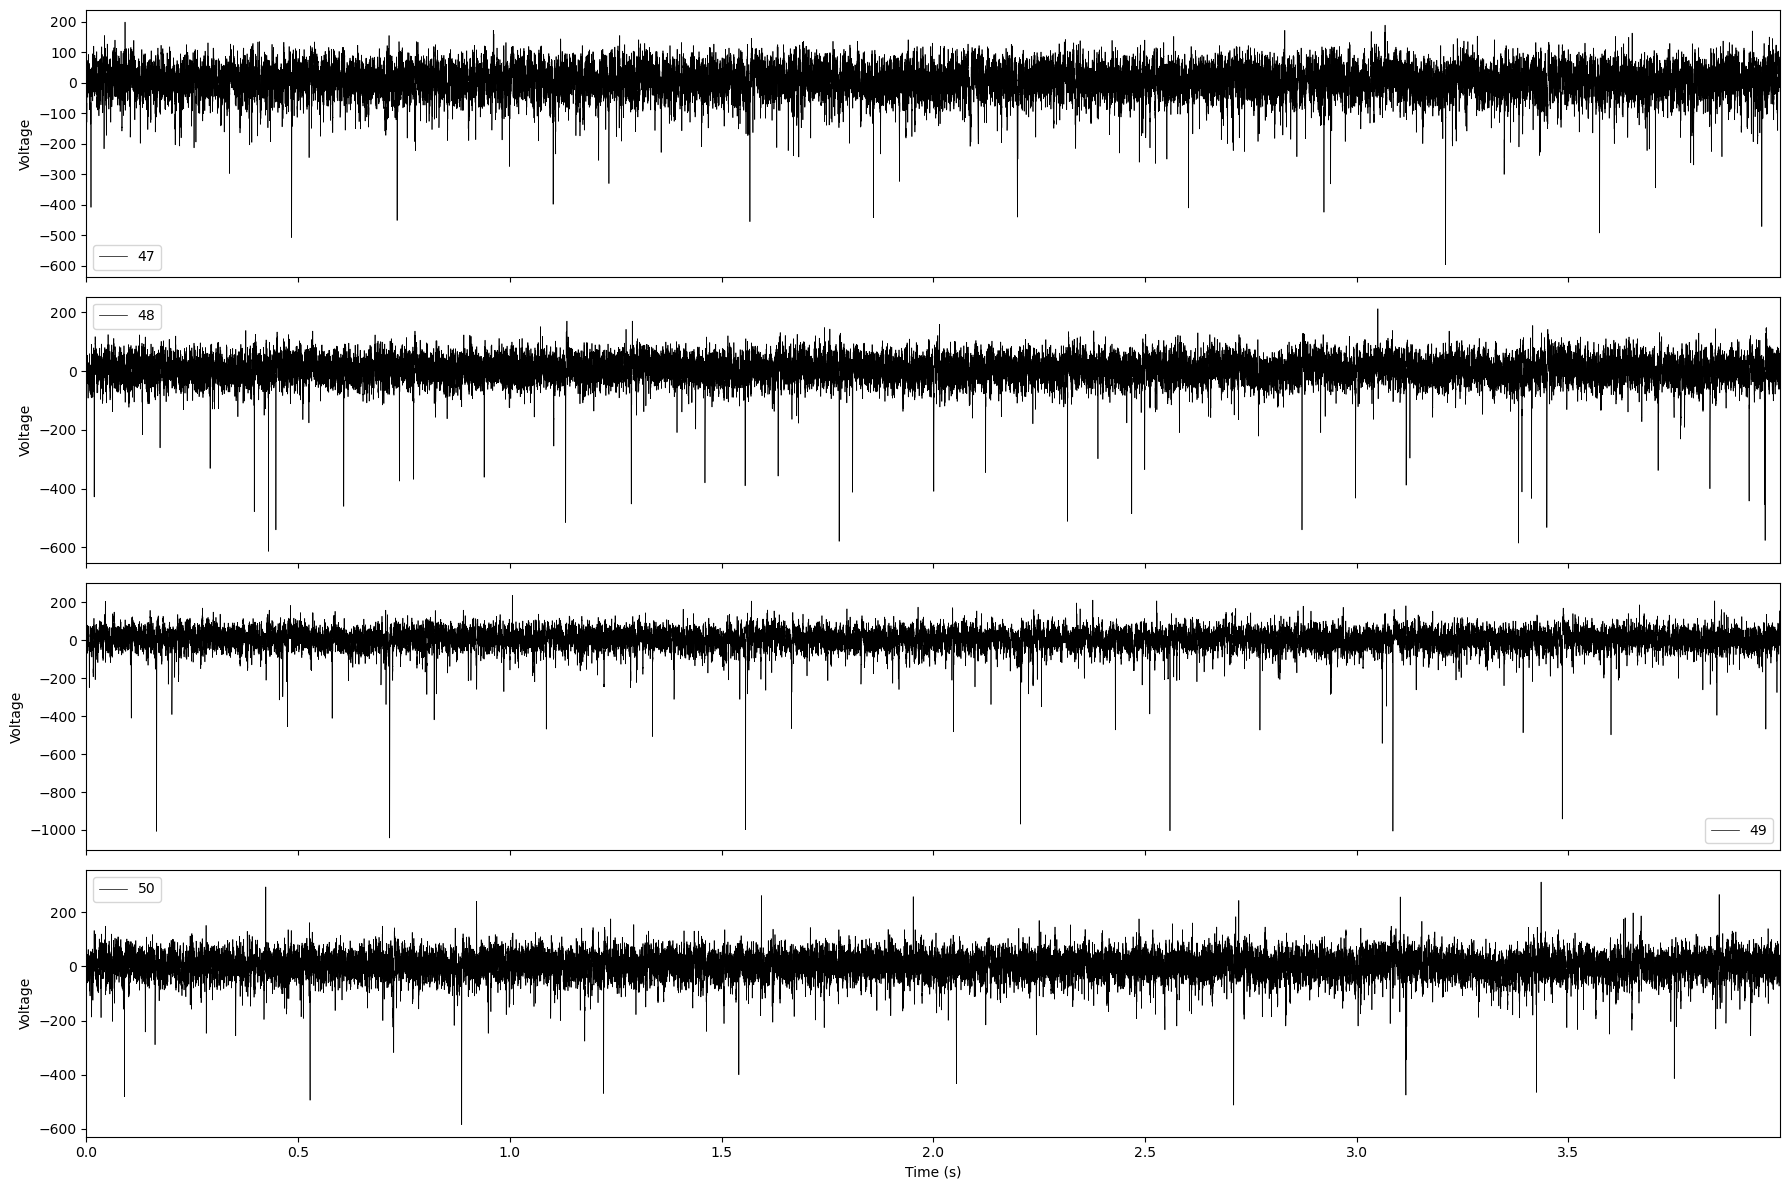

In [107]:
# create a time array for the x axis
time = np.arange(0, len(df)) / SAMPLE_RATE

fig, axs = plt.subplots(len(channels), sharex=True, figsize=(18, 3*len(channels)))

# plot each channel
for i, ax in enumerate(axs):
    ax.plot(time, data[:, i], label=channels[i], lw=0.5, c="k")
    ax.set_ylabel('Voltage')
    ax.legend()  # show a legend for each subplot

axs[-1].set_xlabel('Time (s)')  # only set x-label for the last subplot
plt.xlim(0, max(time))
plt.tight_layout()  # adjust subplot parameters to give specified padding
plt.show()

## Filter Data

In [108]:
# loop through each of the channels and filter them
data_filtered = np.empty_like(data)
for i in range(data.shape[1]):
    data_filtered[:, i] = spike_band_filtering(y=data[:, i], sample_rate=SAMPLE_RATE, low=500, high=4000)


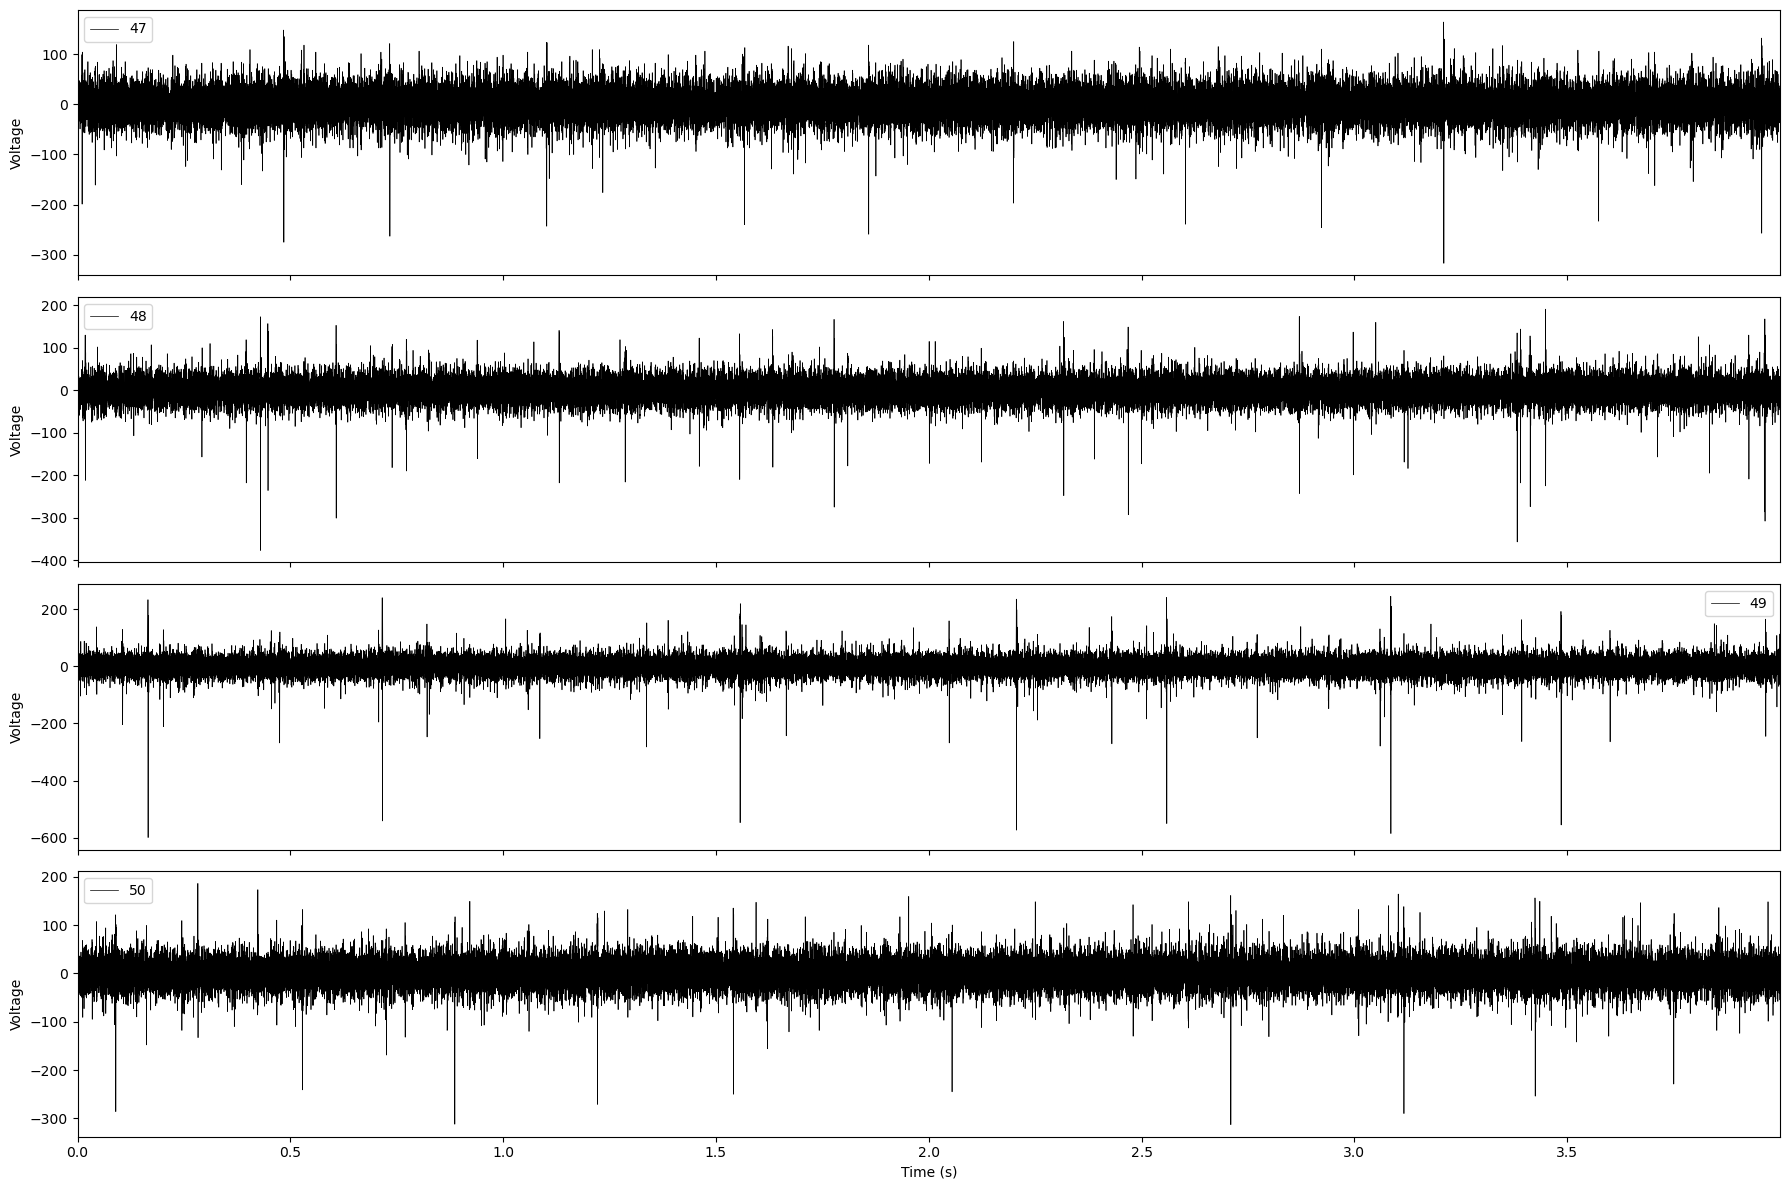

In [109]:
# create a time array for the x axis
time = np.arange(0, len(df)) / SAMPLE_RATE

fig, axs = plt.subplots(len(channels), sharex=True, figsize=(18, 3*len(channels)))

# plot each channel
for i, ax in enumerate(axs):
    ax.plot(time, data_filtered[:, i], label=channels[i], lw=0.5, c="k")
    ax.set_ylabel('Voltage')
    ax.legend()  # show a legend for each subplot

axs[-1].set_xlabel('Time (s)')  # only set x-label for the last subplot
plt.xlim(0, max(time))
plt.tight_layout()  # adjust subplot parameters to give specified padding
plt.show()

We can see the difference that filtering makes by comparing the first channel in the data before and after filtering.

As the software used in recording this data has a built-in high-pass filter, we can see there is not too much difference in the lower frequencies of the signals.

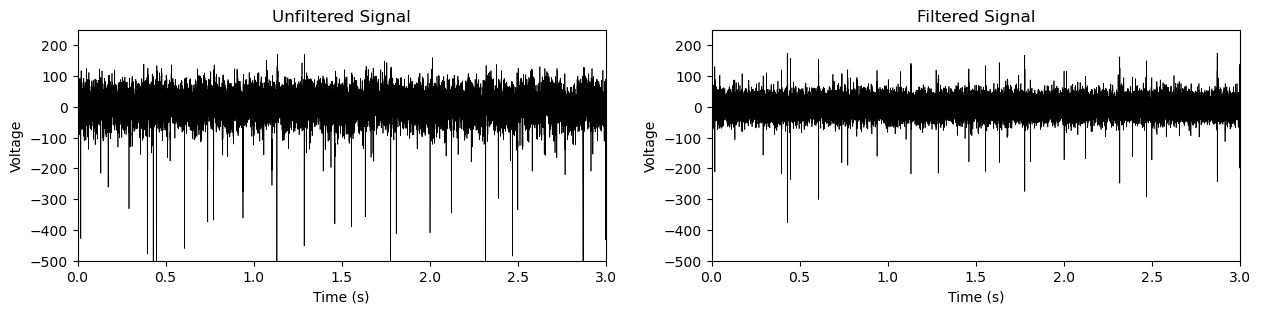

In [110]:
plt.figure(figsize=(15, 3))

# unfiltered signal plot
plt.subplot(1, 2, 1) 
plt.plot(time, data[:, 1], linewidth=.5, c="k")
plt.ylim((-500, 250))
plt.xlim((0, 3))
plt.ylabel('Voltage')
plt.title('Unfiltered Signal')
plt.xlabel("Time (s)")

# filtered signal plot
plt.subplot(1, 2, 2) 
plt.plot(time, data_filtered[:, 1], linewidth=.5, c="k")
plt.ylim((-500, 250))
plt.xlim((0, 3))
plt.ylabel('Voltage')
plt.title('Filtered Signal')
plt.xlabel("Time (s)")

plt.show()

## Spike Detection

In [112]:
# set a threshold mulitplier -> heuristic
threshold_factor = -4

# initialize spikes as an empty list
spikes = []

# loop through each of the channels
for i in range(data_filtered.shape[1]):

    # calculate robust s.d. using the mean absolute deviation (MAD)
    sigma = np.median(np.abs(data_filtered[:, i] - np.median(data_filtered[:, i])) / 0.6745)

    # set the threshold for this channel
    threshold = threshold_factor * sigma

    # detect spikes in this channel
    spikes_channel = detect_spikes(y=data_filtered[:, i], threshold=threshold, minimum_gap=1, use_absolute_threshold=True, flipped=True)

    # append the detected spikes to the list
    spikes.append(spikes_channel)

# convert spikes to a numpy array
spikes = np.array(spikes)

/var/folders/ct/68fpdtpx6lq75x8hr444s83h0000gn/T/ipykernel_5996/1548692611.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spikes = np.array(spikes)


The output array contains arrays of spike peak locations for each channel.

We can then visualise the threshold values for each channel and at which locations this threshold is crossed (a spike).

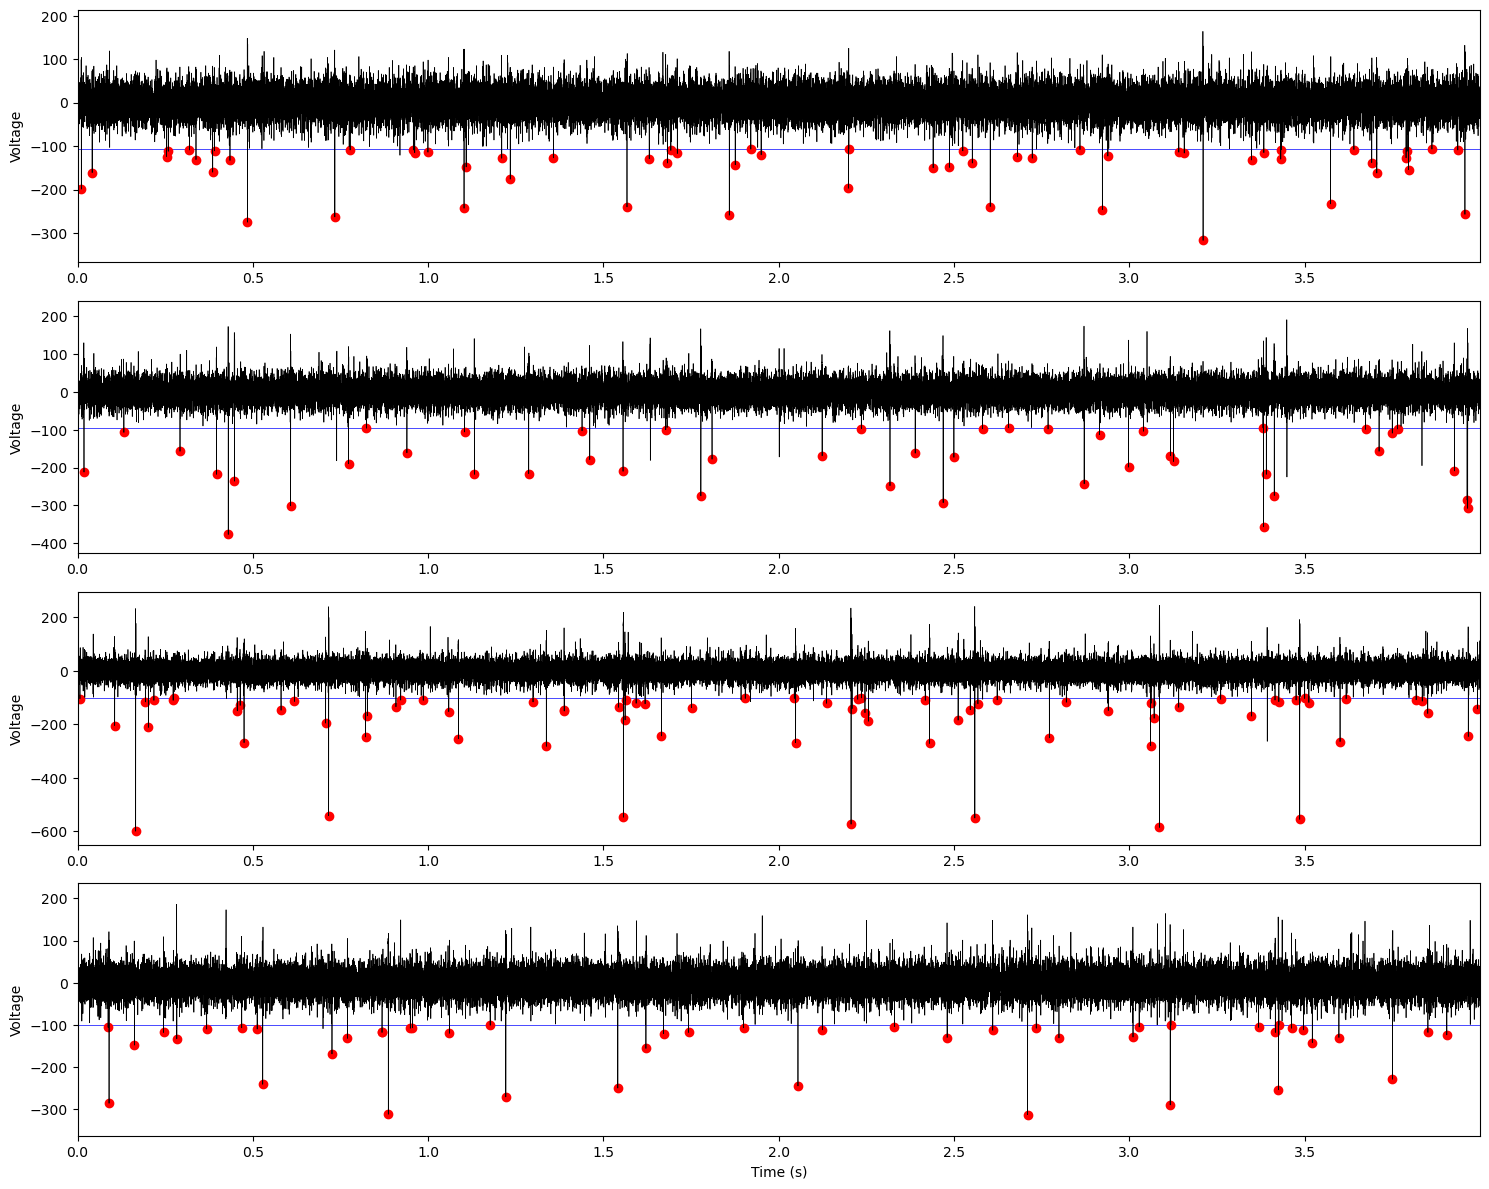

In [138]:
plt.figure(figsize=(15, 3 * data_filtered.shape[1]))

for i in range(data_filtered.shape[1]):
    plt.subplot(data_filtered.shape[1], 1, i+1)
    
    # Plot the signal for this channel
    plt.plot(time, data_filtered[:, i], linewidth=.5, c="k")
    
    # Plot the threshold for this channel
    sigma = np.median(np.abs(data_filtered[:, i] - np.median(data_filtered[:, i])) / 0.6745)
    threshold = -4 * sigma
    plt.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)
    
    # Plot the spike locations for this channel
    plt.scatter(spikes[i] * DT, data_filtered[spikes[i], i], color='red')
    
    plt.ylim((min(data_filtered[:, i]) - 50, max(data_filtered[:, i]) + 50))
    plt.xlim((0, max(time)))
    plt.ylabel('Voltage')

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

## Waveform Extraction

In [139]:
waveforms = []
waveform_info = []

# loop through each of the channels
for i in range(data_filtered.shape[1]):
    # get waveforms for this channel
    waveforms_channel, waveform_info_channel = get_waveforms(y=data_filtered[:, i], spike_indices=spikes[i], duration=1, sample_rate=SAMPLE_RATE, window_shift_ratio=1/3)
    
    # append the waveforms and waveform_info to the lists
    waveforms.append(waveforms_channel)
    waveform_info.append(waveform_info_channel)

# convert waveforms and waveform_info to numpy arrays
waveforms = np.array(waveforms)
waveform_info = np.array(waveform_info)

/var/folders/ct/68fpdtpx6lq75x8hr444s83h0000gn/T/ipykernel_5996/3196610280.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  waveforms = np.array(waveforms)
/var/folders/ct/68fpdtpx6lq75x8hr444s83h0000gn/T/ipykernel_5996/3196610280.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  waveform_info = np.array(waveform_info)


We can then show the waveforms for each channel overlapping...

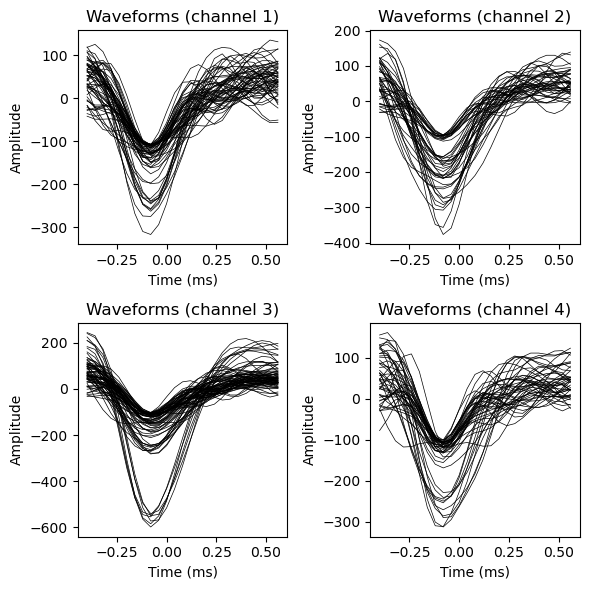

In [152]:
# determine the number of channels
n_channels = waveforms.shape[0]

# calculate the size of the grid
grid_size = int(np.sqrt(n_channels))

# create a figure and subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(6, 6))

# make sure axs is always an array
if n_channels == 1:
    axs = np.array([[axs]])

# iterate over the channels
for i in range(grid_size):
    for j in range(grid_size):
        channel_idx = i * grid_size + j
        # iterate over the waveforms in this channel and plot each on top of each other
        for waveform in waveforms[channel_idx]:
            t = np.arange(-10, 15) * DT * 1000 

            # plot the waveform
            axs[i, j].plot(t, waveform, c="black", lw=.5)

        axs[i, j].set_xlabel('Time (ms)')
        axs[i, j].set_ylabel('Amplitude')
        axs[i, j].set_title(f'Waveforms (channel {channel_idx+1})')

plt.tight_layout()
plt.show()


And how location of the spikes once they have been isolated from their parent signals...

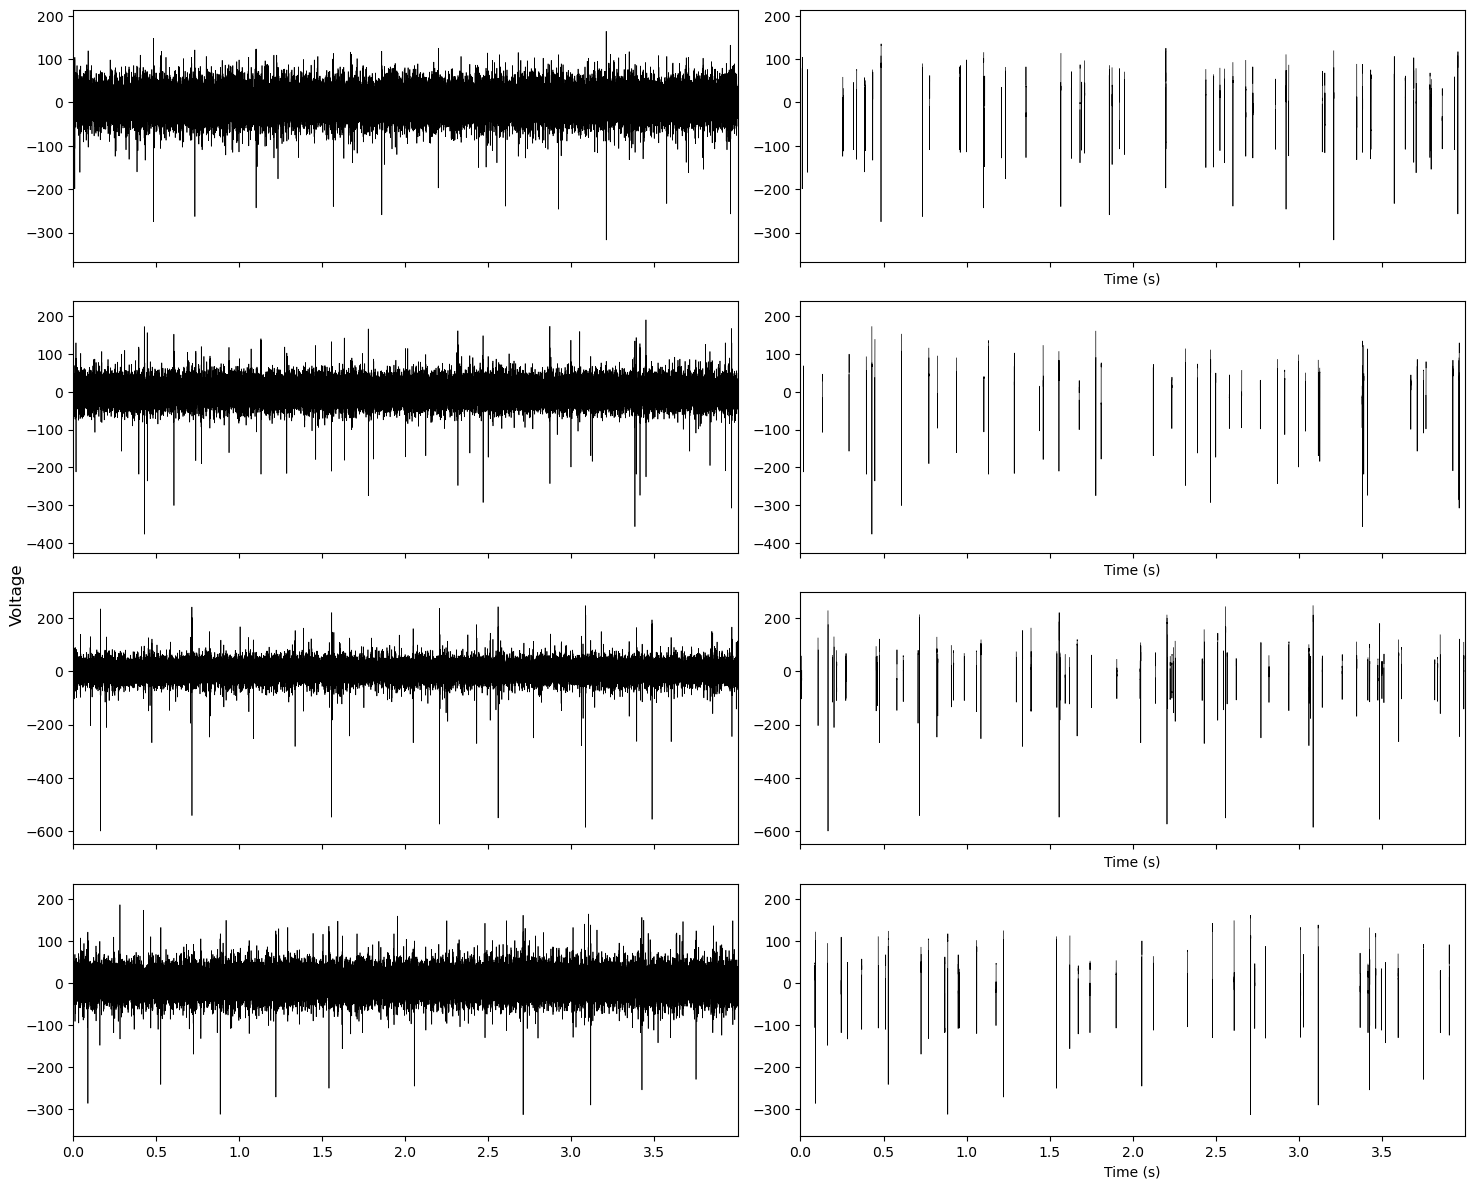

In [157]:
# determine the number of channels
n_channels = data_filtered.shape[1]

# create a figure and subplots
fig, axs = plt.subplots(n_channels, 2, figsize=(15, 3 * n_channels), sharex=True)

# make sure axs is always an array
if n_channels == 1:
    axs = np.array([[axs]])

# iterate over the channels
for i in range(n_channels):

    # plot the raw data for this channel
    axs[i, 0].plot(time, data_filtered[:, i], label='Raw Data', c='k', lw=0.5)
    axs[i, 0].set_ylim((min(data_filtered[:, i]) - 50, max(data_filtered[:, i]) + 50))
    axs[i, 0].set_xlim((0, max(time)))
    
    # iterate through each spike and plot its waveform for this channel
    for spike in waveform_info[i]:
        spike_window = slice(spike["spike_start"], spike["spike_end"])
        axs[i, 1].plot(time[spike_window], data_filtered[:, i][spike_window], c='k', lw=0.5)

    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylim((min(data_filtered[:, i]) - 50, max(data_filtered[:, i]) + 50))
    axs[i, 1].set_xlim((0, max(time)))

fig.supylabel("Voltage")
plt.tight_layout()
plt.show()


## Feature Extraction